# Config

In [2]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [22]:
import os
import sys
import cProfile
import pandas as pd
import geopandas as geopd
import json
import numpy as np
import pycld2
from sklearn.cluster import KMeans
import multiprocessing as mp
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import datetime
import src.utils.geometry as geo
import src.utils.make_config as make_config
import src.utils.scales as scales
import src.data.shp_extract as shp_extract
import src.data.metrics as metrics
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
from dotenv import load_dotenv
load_dotenv()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
pd.reset_option("display.max_rows")

In [13]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
latlon_proj = 'epsg:4326'
LANGS_DICT = dict([(lang[1],lang[0].lower().capitalize())
                   for lang in pycld2.LANGUAGES])
user_level_label = '{}-speaking users'

country_codes = ('BE', 'BO', 'CA', 'CH', 'EE', 'ES', 'FR', 'HK', 'ID', 'LT', 
                 'LV', 'MY', 'PE', 'RO', 'SG', 'TN', 'UA')
with open(os.path.join(external_data_dir, 'countries.json')) as f:
    countries_study_data = json.load(f)
with open(os.path.join(external_data_dir, 'langs_agg.json')) as f:
    langs_agg_dict = json.load(f)
fig_dir = os.path.join('..', 'reports', 'figures')
save_path_format = os.path.join(
    fig_dir, '{cc}', '{metric}', 
    '{metric}_{region}_{grp}cell_size={cell_size}m.pdf')

# Mixing metrics

In [113]:
count_dict = {'name': 'count', 'readable': 'Number', 'log_scale': True,
              'total_count_col': 'total_count', 'vmin': 1, 'cmap': 'Purples'}
repr_dict = {'name': 'repr', 'readable': 'Representation', 'log_scale': True,
             'total_count_col': 'total_count', 'sym_about': 1}
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
conc_dict = {'name': 'conc', 'readable': 'Concentration', 'log_scale': False, 
             'total_count_col': 'total_count'}
KL_dict = {'name': 'KL', 'readable': 'KL divergence', 'global_norm': True,
           'scale_fun': metrics.max_kl, 'log_scale': False,
           'total_count_col': 'total_count', 'sym_about': 0}
Hc_dict = {'name': 'Hc', 'readable': 'Concentration entropy', 
           'scale_fun': metrics.null_Hc, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1, 
           'global_norm': False}
Hp_dict = {'name': 'Hp', 'readable': 'Proportion entropy', 
           'scale_fun': metrics.null_Hp, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1}
EMD_dict = {'name': 'EMD', 'readable': "Earth mover's distance", 
           'log_scale': False, 'total_count_col': 'total_count'}

deal with null cells, how do they impact the metrics?

Hc: the higher, the further from the null model, the less mixing. Pb: space not taken into account

pb with KL: when count of group is 0 (and total one isn't and is actually relevant), you get a divergence = 0, which doesn't make sense. Not a problem when there are users of this group in almost every cell, but can become one when too many relevant cells have a null count, like for multilingual groups

two kinds of null values: total count is 0 and lang count is 0

atm, a null lang count is in grey, and a null total count in white. choose a visually more pleasant color for null lang count?

## Belgium

In [42]:
cc = 'BE'
region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)

cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=6, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

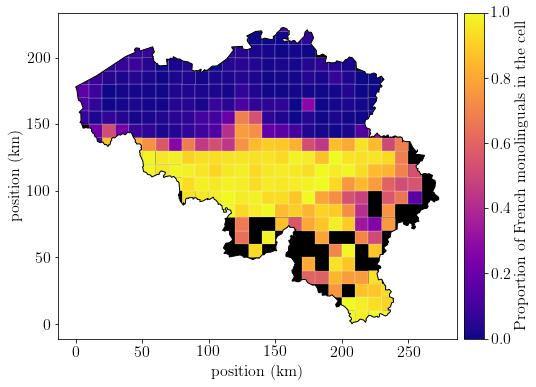

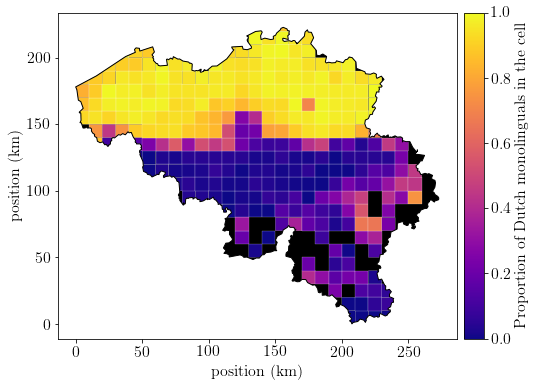

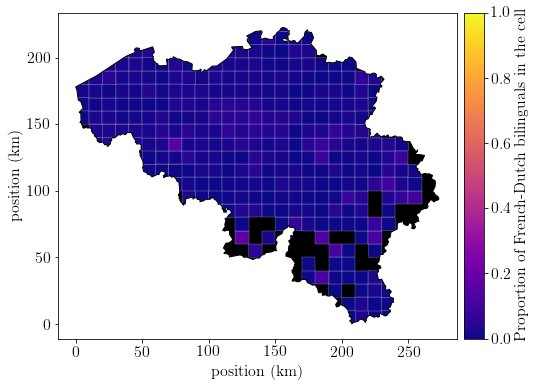

In [30]:
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

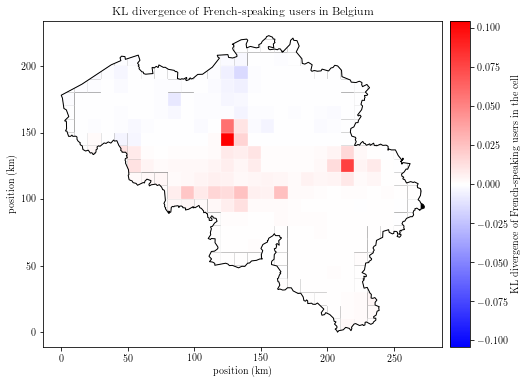

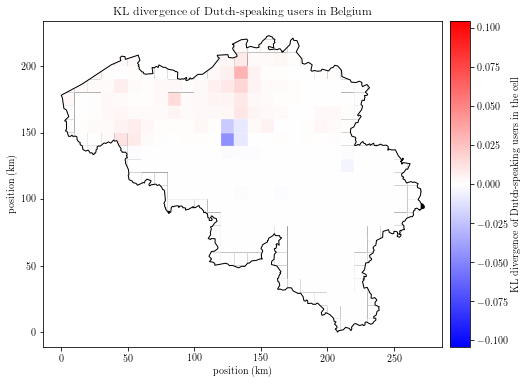

In [41]:
ax = helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

In [43]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

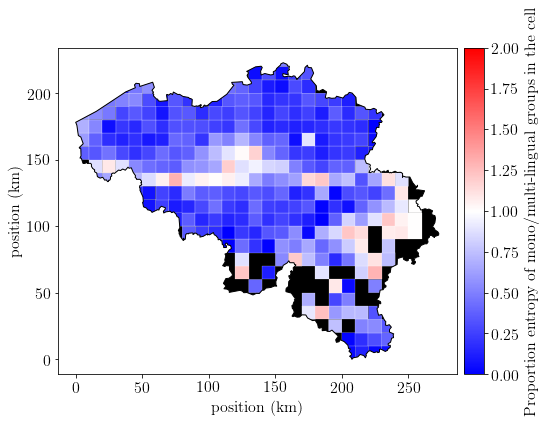

In [44]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

In [32]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the French-speaking users is: 0.12164586885380824.
The Concentration entropy for the Dutch-speaking users is: 0.007362814511328919.
The Concentration entropy averaged over all groups is 0.033141950498156506.
The KL divergence for the French-speaking users is: 0.9144480674305526.
The KL divergence for the Dutch-speaking users is: 0.4881675257308824.
The KL divergence averaged over all groups is 0.6799868421056324.


In [33]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi'], total_dict, d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.2809917355371901
The Concentration entropy for the French-speaking users is: 0.12139989965299602.
The Concentration entropy for the Dutch-speaking users is: 0.007744109881952843.
The Concentration entropy averaged over all groups is 0.03327520933778848.
The KL divergence for the French-speaking users is: 0.9144480674305526.
The KL divergence for the Dutch-speaking users is: 0.4881675257308824.
The KL divergence averaged over all groups is 0.6799868421056324.
The EMD between the distributions of multilinguals and of the total population is 0.09488537391297433.
8017.897545548734 84500.87948119886


In [36]:
_, _, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

grps_dict = plot_langs_dict
for grp, grp_dict in grps_dict.items():
    count_col = grp_dict['count_col']
    conc_col = grp_dict['conc_col']
    n_samples = cell_plot_df[count_col].sum()
    ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 'total_conc', 
                                           Nx, Ny, n_samples)
    print(grp, ks_score, p_value)
    chi2_score, normed_score, p_value = metrics.grid_chisquare(
        cell_plot_df, conc_col, 'total_conc', n_samples)
    print(grp, normed_score, p_value)

fr 0.40004168427350506 0.0
fr 1.2506201907608219 0.0
nl 0.2607372596337826 0.0
nl 0.40063598747136026 0.0


In [156]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.4368810060400594
The Concentration entropy for the French monolinguals is: 0.8722684620258012.
The Concentration entropy for the Dutch monolinguals is: 0.9992067419197258.
The Concentration entropy for the French-Dutch bilinguals is: 0.9009427309916483.
The Concentration entropy averaged over all groups is 0.9586006939822082.
The KL divergence for the French monolinguals is: 0.6409798716576481.
The KL divergence for the Dutch monolinguals is: 0.6926123752507499.
The KL divergence for the French-Dutch bilinguals is: 0.10808882065709233.
The KL divergence averaged over all groups is 0.6239909623935143.


Wouldnt log(repr) be better suited? Problem: cells with repr == 0 -> then clusters with entropy/KL div?

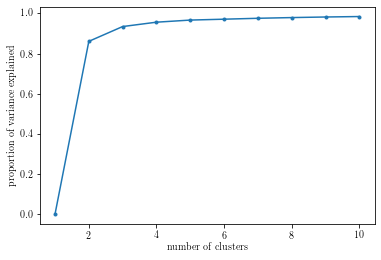

In [38]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

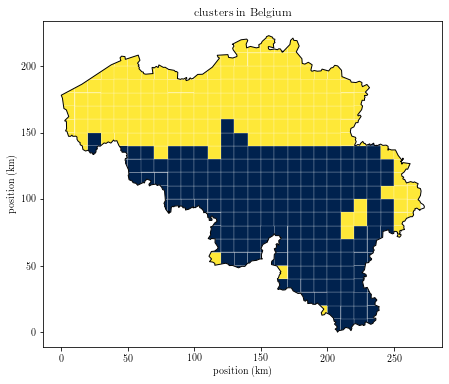

In [39]:
n_clusters_to_keep = 2
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
plot_kwargs = dict(edgecolor='w', linewidths=0.2, 
                   cmap=cm.get_cmap('cividis', n_clusters_to_keep))
ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, metric_col='cluster', save_path=None, 
    title=plot_title, cbar_label=cbar_label, xy_proj=xy_proj, 
    **plot_kwargs)

## Spain

In [242]:
cc = 'ES'
region = 'Catalonia'
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

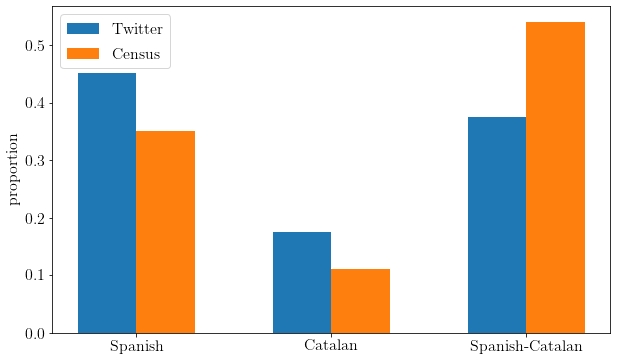

In [252]:
census_es_ratio = 0.35
census_ca_ratio = 0.11
census_caes_ratio = 1 - 0.11 - 0.35
census_ratios = [census_es_ratio, census_ca_ratio, census_caes_ratio]
total = cell_plot_df['local_count'].sum()
twitter_es_ratio = cell_plot_df['count_ling_es'].sum() / total
twitter_ca_ratio = cell_plot_df['count_ling_ca'].sum() / total
twitter_caes_ratio = cell_plot_df['count_ling_caes'].sum() / total
twitter_ratios = [twitter_es_ratio, twitter_ca_ratio, twitter_caes_ratio]
fig, ax = plt.subplots(1, figsize=(10, 6))
width = 0.3
xticks = np.array([1, 2, 3])
p1 = ax.bar(xticks, twitter_ratios, width)
p2 = ax.bar(xticks + width, census_ratios, width)

ax.set_xticks(xticks + width / 2)
ax.set_xticklabels(('Spanish', 'Catalan', 'Spanish-Catalan'))
ax.set_ylabel('proportion')
ax.legend((p1[0], p2[0]), ('Twitter', 'Census'))
ax.autoscale_view()
plt.savefig(os.path.join(fig_dir, cc, 'cat_twiter_vs_census_lingual_groups.pdf'),
            bbox_inches='tight')
plt.show()

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_langs_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=6, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

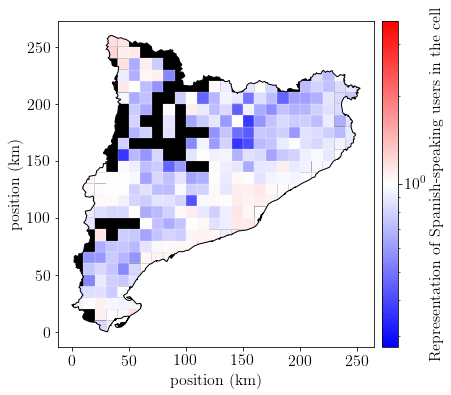

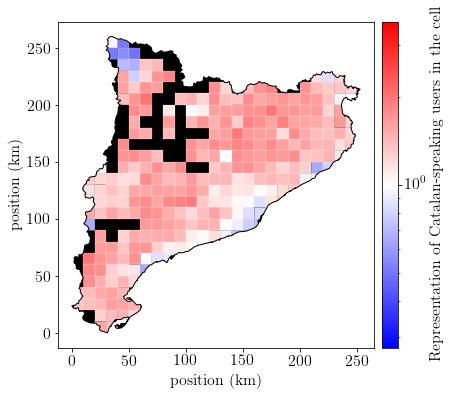

In [37]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [46]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

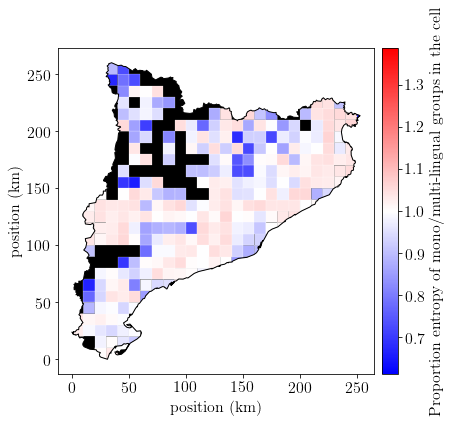

In [47]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

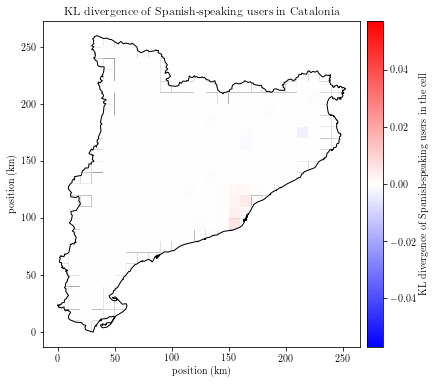

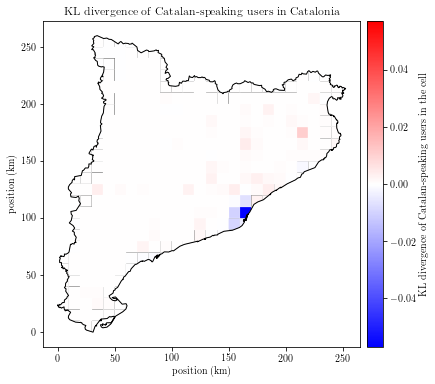

In [106]:
ax = helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

In [19]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the Spanish-speaking users is: 0.9679253809940158.
The Concentration entropy for the Catalan-speaking users is: 1.1095512588663359.
The Concentration entropy averaged over all groups is 0.07585687977267806.
The KL divergence for the Spanish-speaking users is: 0.20385035633976598.
The KL divergence for the Catalan-speaking users is: 0.30519336556673904.
The KL divergence averaged over all groups is 0.29269155448624073.


In [90]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi'], total_dict, d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.028795811518324606
The Concentration entropy for the Catalan monolinguals is: 0.20071843432296488.
The Concentration entropy for the Spanish monolinguals is: 0.09190087109163503.
The Concentration entropy for the multilinguals is: 0.040561471016655304.
The Concentration entropy averaged over all groups is 0.08904803379260717.
The KL divergence for the Catalan monolinguals is: 0.4294538773568471.
The KL divergence for the Spanish monolinguals is: 0.15684734755026322.
The KL divergence for the multilinguals is: 0.10493041326974215.
The KL divergence averaged over all groups is 0.1720533226062847.
The EMD between the distributions of multilinguals and of the total population is 0.031431978874803194.
2845.8695923934215 90540.57982568686


In [21]:
_, _, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

grps_dict = plot_langs_dict
for grp, grp_dict in grps_dict.items():
    count_col = grp_dict['count_col']
    conc_col = grp_dict['conc_col']
    n_samples = cell_plot_df[count_col].sum()
    ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 'total_conc', 
                                           Nx, Ny, n_samples)
    print(grp, ks_score, p_value)
    chi2_score, normed_score, p_value = metrics.grid_chisquare(
        cell_plot_df, conc_col, 'total_conc', n_samples)
    print(grp, normed_score, p_value)

[0.15142930539887733, 0.1807604429764223, 0.14980980537434124, 0.14981020200442297]
mono_ling_ca 0.1807604429764223 0.0
mono_ling_ca 0.26861835026663344 0.0
[0.061688007467650685, 0.07638733620487093, 0.060773960035376495, 0.06075710531412143]
mono_ling_es 0.07638733620487093 3.3506051648624743e-226
mono_ling_es 0.05840672484100866 0.0
[0.03250623275719611, 0.038022372161026774, 0.028001223322509816, 0.02788038748522209]
multi 0.038022372161026774 5.1954061998951745e-36
multi 0.020215046879011232 8.264992734777066e-18


In [160]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.960887183121997
The Concentration entropy for the Catalan monolinguals is: 1.2010022023230005.
The Concentration entropy for the Spanish monolinguals is: 0.9082914308809532.
The Concentration entropy for the Catalan-Spanish bilinguals is: 1.0408714689430467.
The Concentration entropy averaged over all groups is 1.0135401750620867.
The KL divergence for the Catalan monolinguals is: 0.2609221887068473.
The KL divergence for the Spanish monolinguals is: 0.1803654539173365.
The KL divergence for the Catalan-Spanish bilinguals is: 0.085128700875913.
The KL divergence averaged over all groups is 0.1720533226062847.


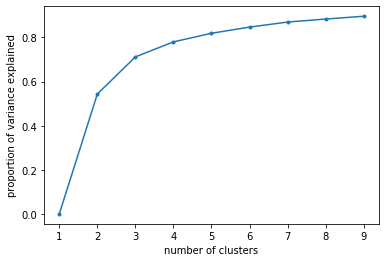

In [60]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

With 2 clusters, we explain just a bit more than 50% of the variance -> can illustrate qualitative difference bewteen cat and be or ch

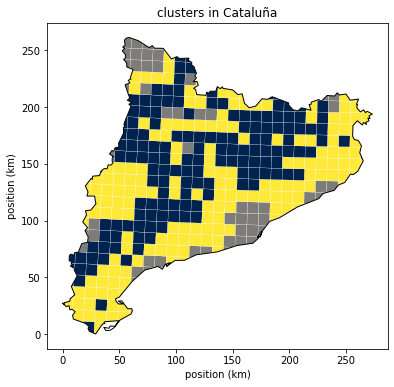

In [7]:
n_clusters_to_keep = 3
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
# Avoid sequential colormaps starting or ending with white, as white is  
# reserved for an absence of data
plot_kwargs = dict(edgecolor='w', linewidths=0.2, 
                   cmap=cm.get_cmap('cividis', n_clusters_to_keep))
ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, metric_col='cluster', save_path=None, 
    title=plot_title, cbar_label=cbar_label, xy_proj=xy_proj, 
    **plot_kwargs)

## Switzerland

In [201]:
cc = 'CH'
region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=6, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

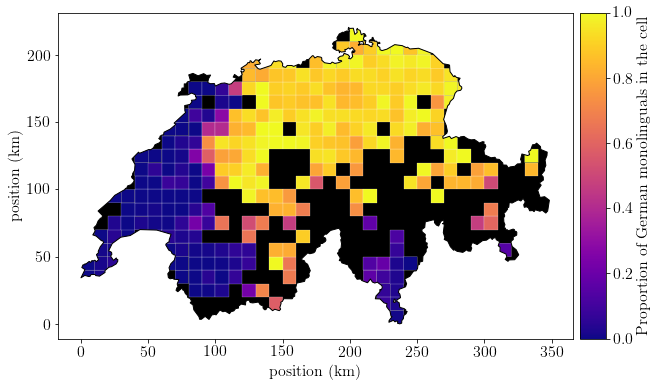

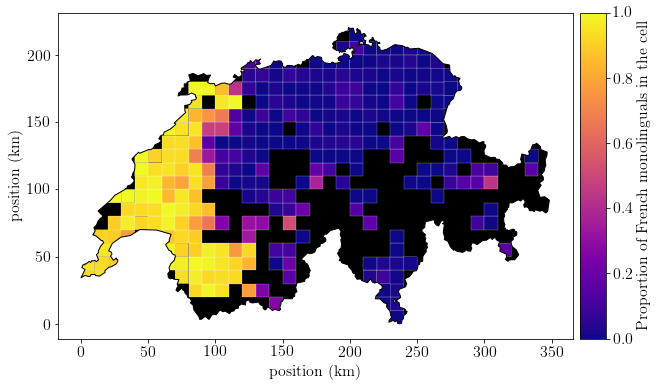

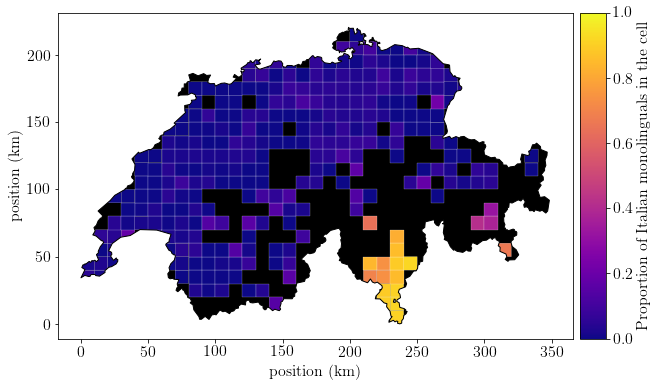

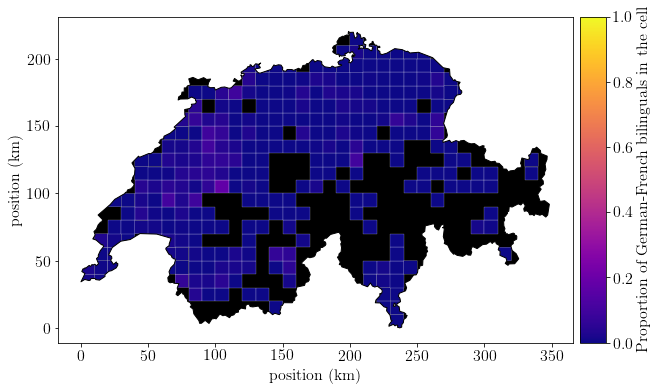

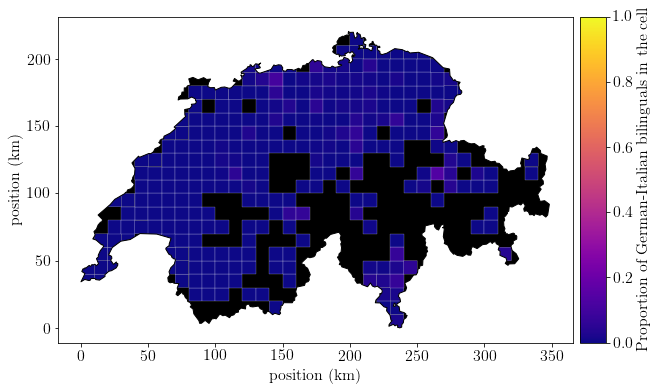

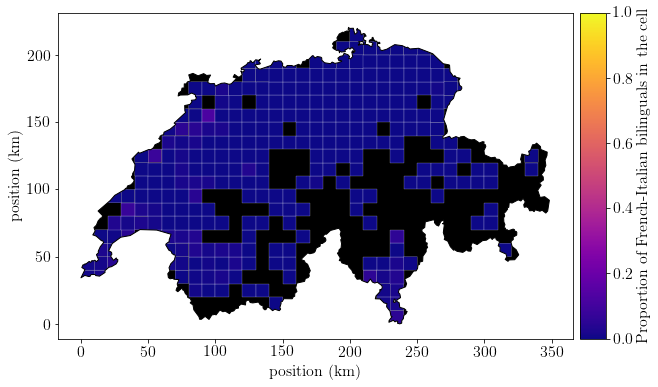

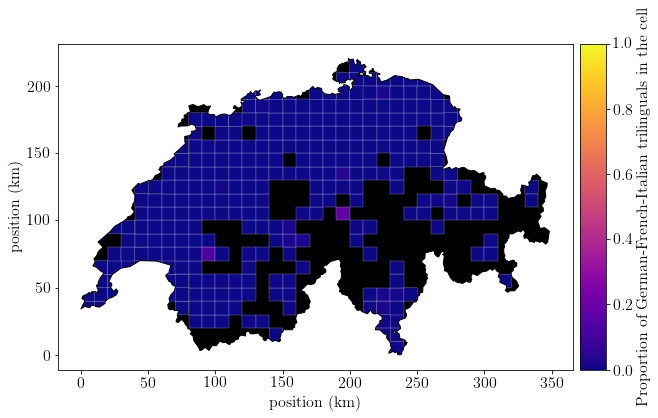

In [25]:
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [26]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

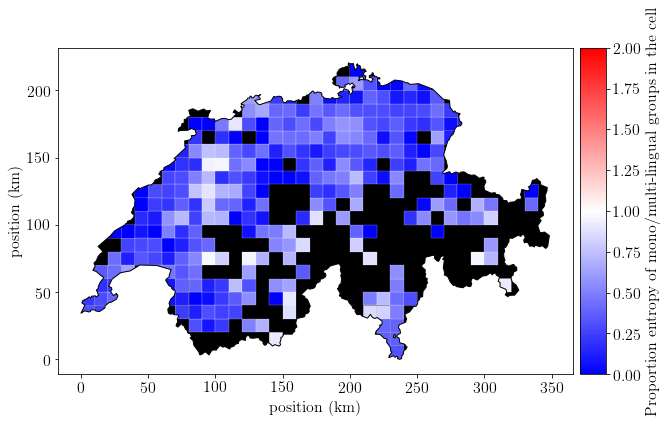

In [27]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

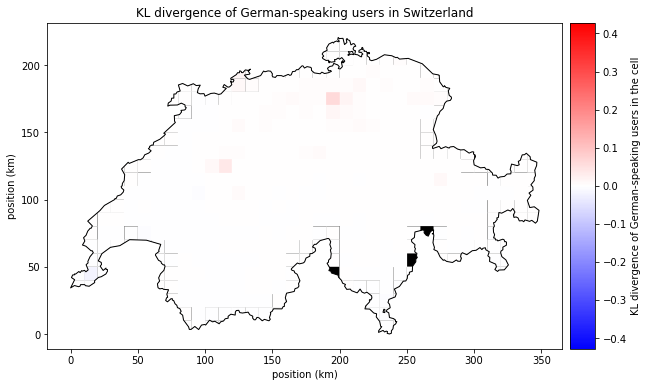

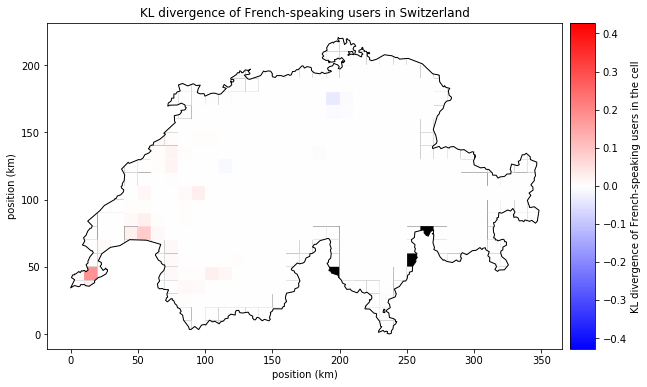

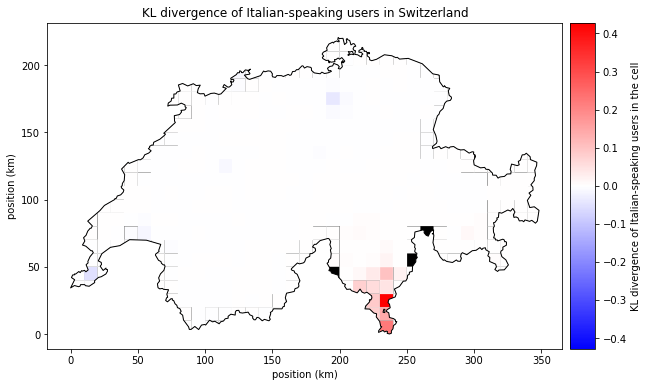

In [89]:
ax = helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

In [36]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the German-speaking users is: 0.98499164504712.
The Concentration entropy for the French-speaking users is: 0.8259617306363651.
The Concentration entropy for the Italian-speaking users is: 0.8817308734347101.
The Concentration entropy averaged over all groups is 0.0527397210218581.
The KL divergence for the German-speaking users is: 0.4782027490018117.
The KL divergence for the French-speaking users is: 0.6454604111239606.
The KL divergence for the Italian-speaking users is: 0.5853167321112569.
The KL divergence averaged over all groups is 0.3185935414504748.


In [154]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.3904249480526555
The Concentration entropy for the German monolinguals is: 0.9775722641769954.
The Concentration entropy for the French monolinguals is: 0.8079523621157346.
The Concentration entropy for the Italian monolinguals is: 0.8409376310165656.
The Concentration entropy for the German-French bilinguals is: 0.8593756621239426.
The Concentration entropy for the German-Italian bilinguals is: 0.9128091882191087.
The Concentration entropy for the French-Italian bilinguals is: 0.7500031836600045.
The Concentration entropy for the German-French-Italian trilinguals is: 0.501637060477667.
The Concentration entropy averaged over all groups is 0.8912178800999762.
The KL divergence for the German monolinguals is: 0.4549299719673681.
The KL divergence for the French monolinguals is: 0.628967450302419.
The KL divergence for the Italian monolinguals is: 0.6250579132789522.
The KL divergence for the German-French bilinguals is: 0.2001113510206

In [37]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi'], total_dict, d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.48268839103869654
The Concentration entropy for the German monolinguals is: 0.023289675017457157.
The Concentration entropy for the French monolinguals is: 0.19444814998989646.
The Concentration entropy for the Italian monolinguals is: 0.16533724915730752.
The Concentration entropy for the multilinguals is: 0.02835129805367631.
The Concentration entropy averaged over all groups is 0.057094292399672945.
The KL divergence for the German monolinguals is: 0.6293310808415099.
The KL divergence for the French monolinguals is: 0.951508688867573.
The KL divergence for the Italian monolinguals is: 1.9179800128201494.
The KL divergence for the multilinguals is: 0.6663183444303225.
The KL divergence averaged over all groups is 0.5261005738368818.
The EMD between the distributions of multilinguals and of the total population is 0.18079793117393853.
20930.20603482003 115765.73857299233


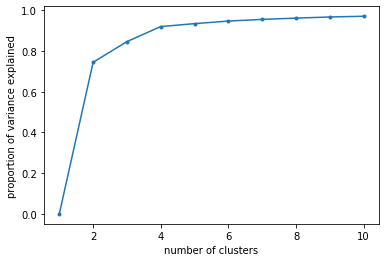

In [10]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

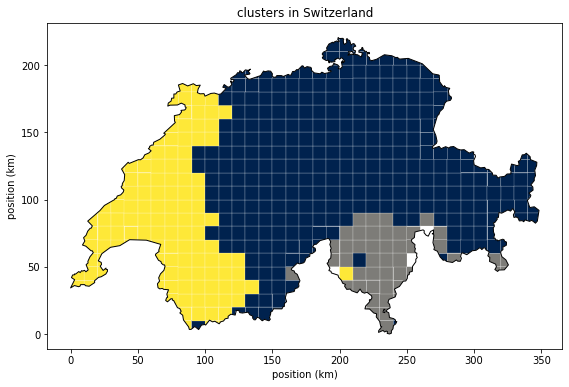

In [11]:
n_clusters_to_keep = 3
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
# Avoid sequential colormaps starting or ending with white, as white is  
# reserved for an absence of data
plot_kwargs = dict(edgecolor='w', linewidths=0.2, 
                   cmap=cm.get_cmap('cividis', n_clusters_to_keep))
ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, metric_col='cluster', save_path=None, 
    title=plot_title, cbar_label=cbar_label, xy_proj=xy_proj, 
    **plot_kwargs)

## Quebec

In [166]:
cc = 'CA'
region = 'Quebec'
cell_size = 20000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=5, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

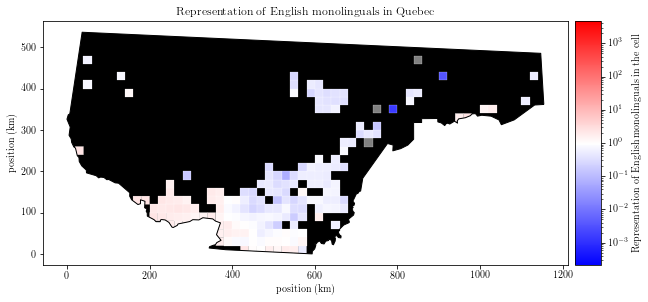

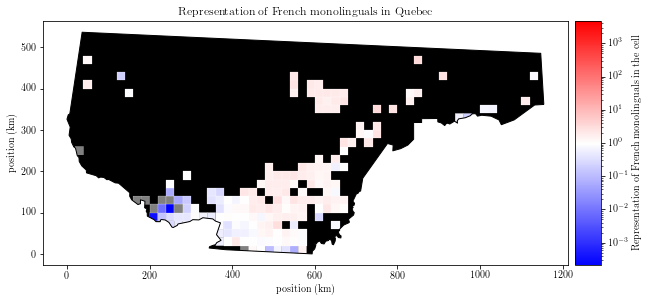

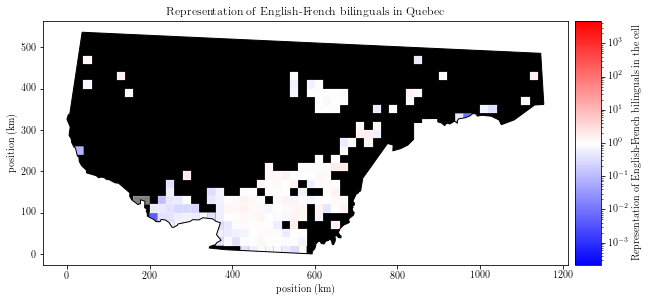

In [172]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [169]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

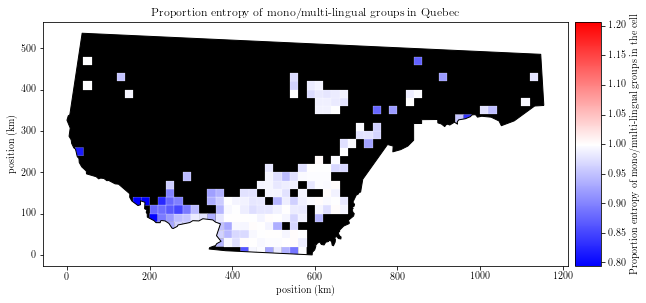

In [170]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

Here: test to add cells with 0 pop, and see how it affects the two normed EMD

--> test conclusive by using min of total conc to weigh the norm. Could also simply calculate the norm on non empty cells (pb: many cells with barely 0 but not 0), then put a threshold, but that's maybe just pushing back the pb without eliminating it

In [14]:
new_cells, _, _, _ = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

In [15]:
a = new_cells.join(cell_plot_df[['conc_fr', 'conc_en', 'total_conc']])
a.loc[a['conc_fr'].isnull(), 'conc_fr'] = 0
a.loc[a['conc_en'].isnull(), 'conc_en'] = 0
a.loc[a['total_conc'].isnull(), 'total_conc'] = 0
emd_value, norm, d_matrix = metrics.earthmover_distance(
    a, plot_langs_dict['fr'], plot_langs_dict['en'], d_matrix=None)
print(emd_value / np.mean(d_matrix))
print(emd_value / norm)
print(emd_value, norm, np.mean(d_matrix))

0.11071694747442906
0.19331547011000164
50759.36949008027 262572.72354456084 458460.70224979374


## US

In [21]:
cc = 'US'
region = 'New York City'
cell_size = 2000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = repr_dict
metric = metric_dict['name']
file_name = f'lang_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_langs_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=8, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

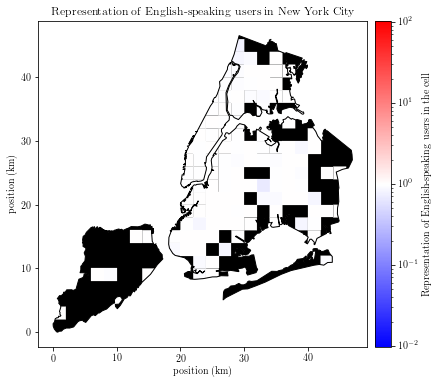

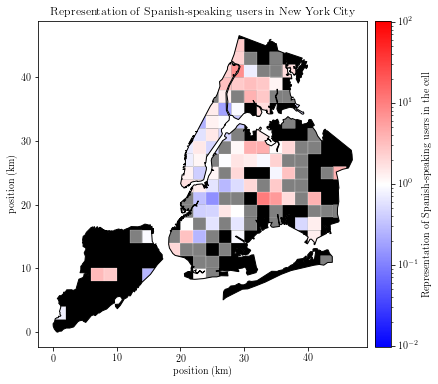

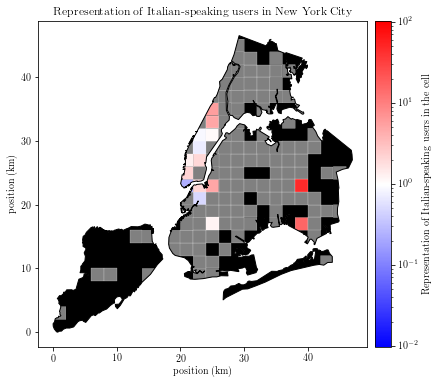

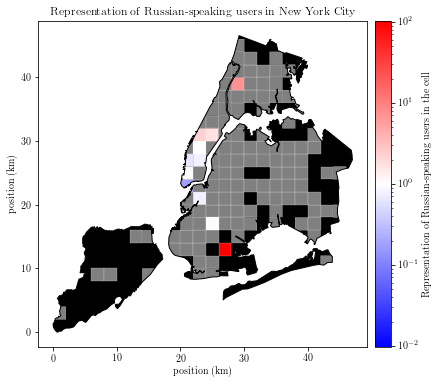

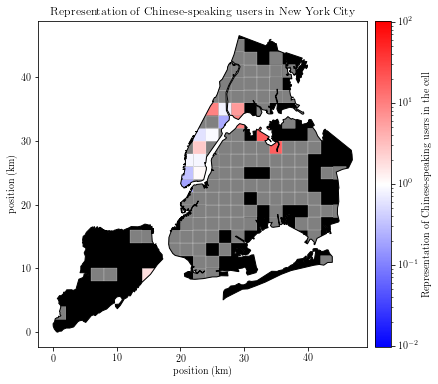

In [23]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [24]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

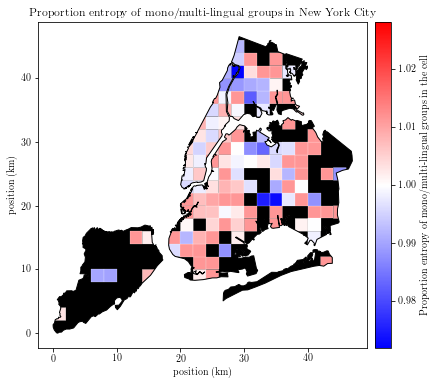

In [25]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

## Malaysia

In [173]:
cc = 'MY'
region = None
cell_size = 20000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=4, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

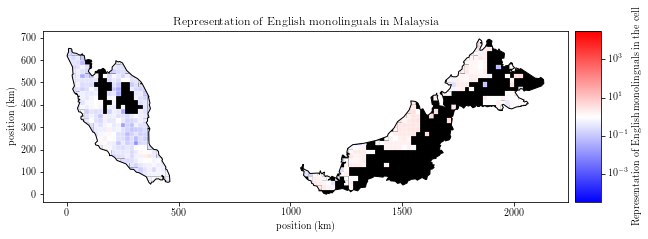

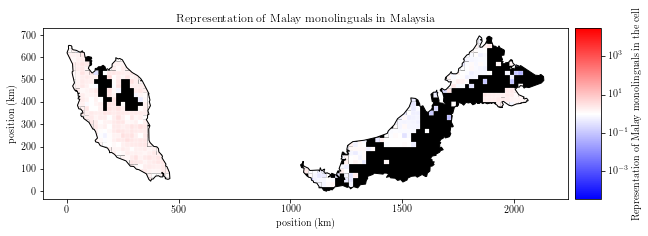

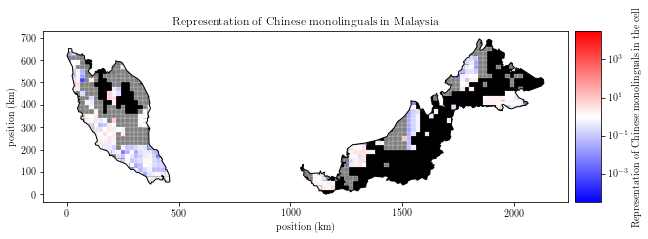

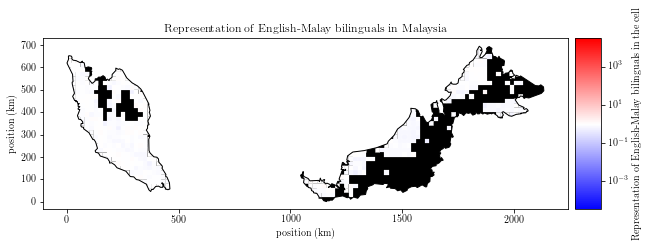

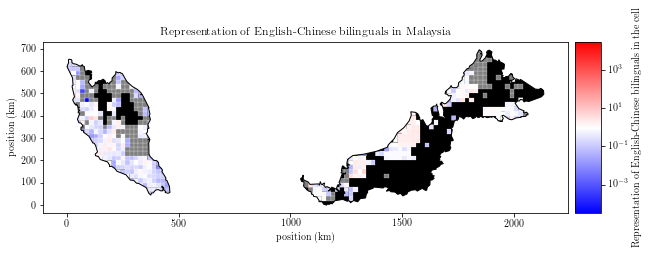

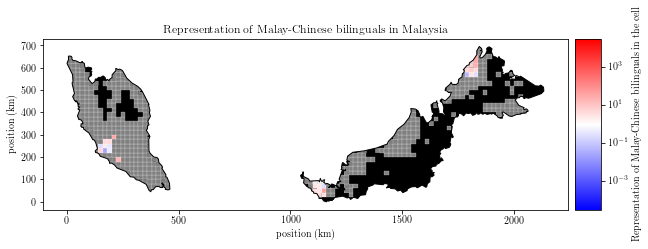

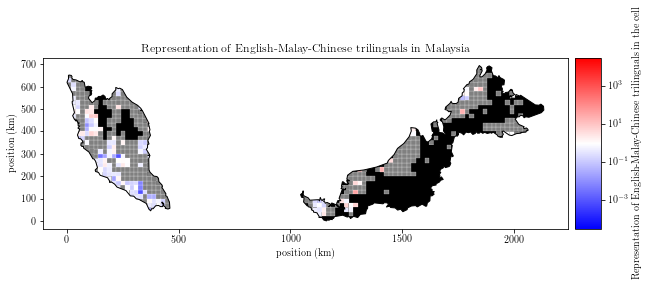

In [179]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [176]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

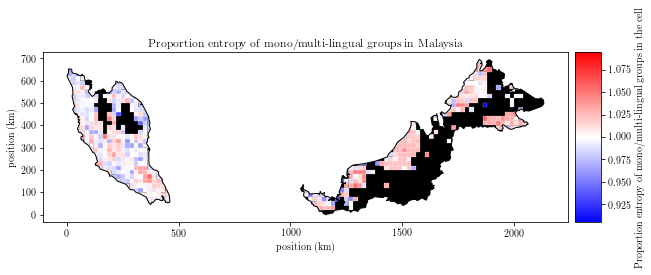

In [177]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

## Others

In [326]:
cc = 'CY'
region = None
cell_size = 5000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [329]:
metric_dict = count_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=7, colorscale='Plasma', 
    plotly_renderer='iframe_connected', save_path=save_path, show=True)

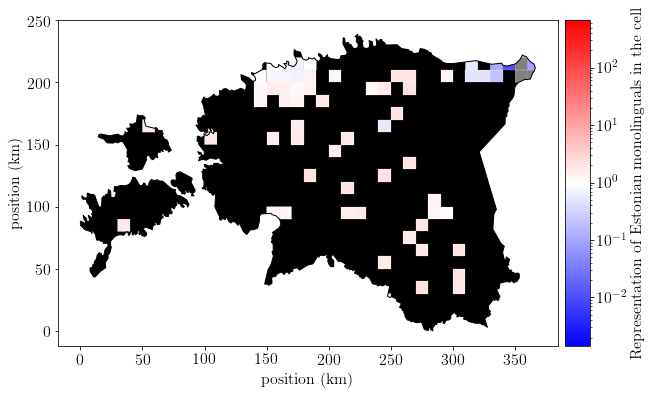

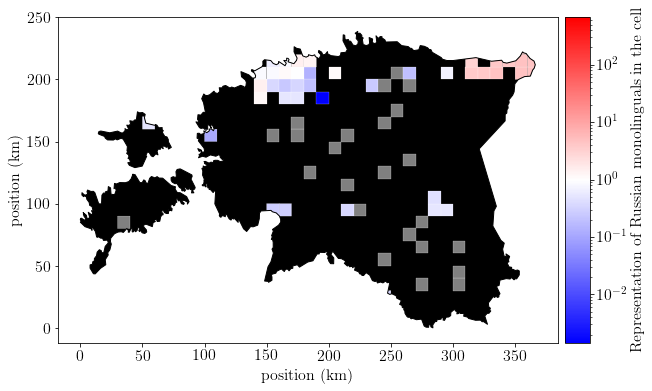

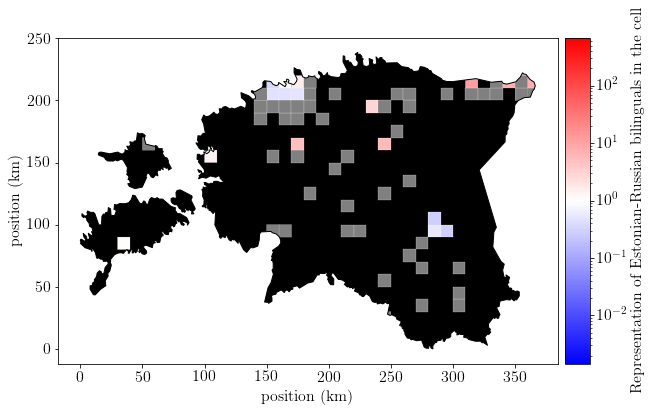

In [318]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
ax = helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [319]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

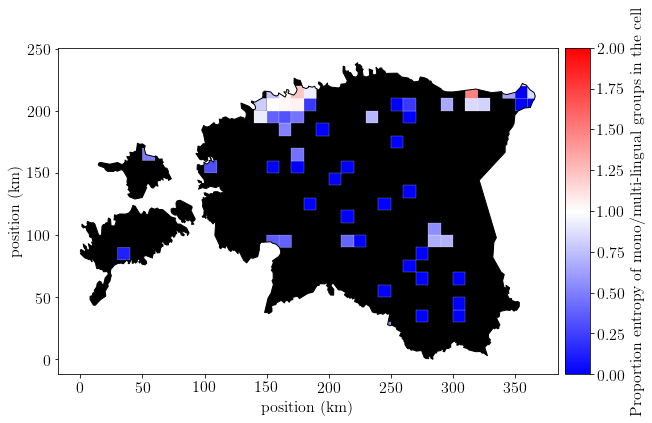

In [320]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

possibility: (i) how are multilinguals distributed wrt local pop, and then (ii) how mixed are monolinguals

(i): test KL divergence of multiling (summing counts of all bi-trilinguals) from local count. Pb: when too few multilinguals overall, poor results because of cells with multiling_count == 0. Can also try Hc and distribution tests. Way to measure how complementary multilinguals are to monolinguals? like compare to 1-mono

(ii): take one of the entropies, or sort of weighted average (weighted how?) of in-between groups distribution divergences, or weighted average of divergences between langs and local (total?) pop

maybe fractal dimension (-> if close to 1, means biliguals on border, on a line)?  use more the proportions for ling groups, and try fabio like entropy that could work well here


High entropy (so high diversity) where high prop of multilinguals/at the borders between monolinguals?

# Countries "phase space"

In [304]:
user_level_label = '{}-speaking users'
save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
countries_dict = {
    'Uruguay': {'cc': 'UY', 'region': None, 'cell_sizes': [20000]},
    'Paraguay': {'cc': 'PY', 'region': None, 'cell_sizes': [30000, 40000]},
    'Cyprus': {'cc': 'CY', 'region': None, 'cell_sizes': [5000, 10000]},
    'Luxembourg': {'cc': 'LU', 'region': None, 'cell_sizes': [2000, 5000]},
    'Algeria': {'cc': 'DZ', 'region': None, 'cell_sizes': [40000, 60000]},
    'Morocco': {'cc': 'MA', 'region': None, 'cell_sizes': [20000, 40000]},
    'Finland': {'cc': 'FI', 'region': None, 'cell_sizes': [40000]},
#     'SG': {'region': None, 'cell_sizes': [1000, 2000]},
    'CH': {'cc': 'CH', 'region': None, 'cell_sizes': [10000, 15000]},
    'BE': {'cc': 'BE', 'region': None, 'cell_sizes': [5000, 10000, 15000]},
    'Catalonia': {'cc': 'ES', 'region': 'Catalonia', 'cell_sizes': [5000, 10000, 15000]},
    'Balearic islands': {'cc': 'ES', 'region': 'Balearic islands', 'cell_sizes': [5000, 10000]},
    'Galicia': {'cc': 'ES', 'region': 'Galicia', 'cell_sizes': [10000]},
    'Valencian Community': {'cc': 'ES', 'region': 'Valencian Community', 'cell_sizes': [5000, 10000]},
    'Basque country': {'cc': 'ES', 'region': 'Basque country', 'cell_sizes': [5000, 10000]},
    'Latvia': {'cc': 'LV', 'region': None, 'cell_sizes': [10000]},
    'Estonia': {'cc': 'EE', 'region': None, 'cell_sizes': [10000]},
    'Florida': {'cc': 'US', 'region': 'Florida', 'cell_sizes': [20000]},
    'Louisiana': {'cc': 'US', 'region': 'Louisiana', 'cell_sizes': [20000]},
    'Texas': {'cc': 'US', 'region': 'Texas', 'cell_sizes': [20000]},
    'New Mexico': {'cc': 'US', 'region': 'New Mexico', 'cell_sizes': [20000]},
    'Arizona': {'cc': 'US', 'region': 'Arizona', 'cell_sizes': [20000]},
    'Nevada': {'cc': 'US', 'region': 'Nevada', 'cell_sizes': [20000]},
    'California': {'cc': 'US', 'region': 'California', 'cell_sizes': [20000]},
    'Quebec': {'cc': 'CA', 'region': 'Quebec', 'cell_sizes': [20000]},
    'Malaysia': {'cc': 'MY', 'region': None, 'cell_sizes': [20000]},
    'Indonesia': {'cc': 'ID', 'region': None, 'cell_sizes': [40000]},
}

In [305]:
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
# plot_countries_dict = {}
with open(save_path) as f:
    plot_countries_dict = json.load(f)
for _, cc_dict in countries_dict.items():
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)

    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    shapefile_path = os.path.join(
        external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
    shape_df = geopd.read_file(shapefile_path)
    min_poly_area = area_dict.get('min_poly_area')
    shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                 min_area=min_poly_area)
    
    for cell_size in cc_dict['cell_sizes']:
        case_name = f'{area_name}{cell_size/1000:.0f}'
        case_dict = plot_countries_dict.get(case_name) or {}
        case_dict['name'] = case_name
        print(f'-- {case_name}')
        d_matrix = None
        _, _, Nx, Ny = geo.create_grid(
            shape_df, cell_size, xy_proj=xy_proj, intersect=False)
        cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, cell_size, 'geojson')
        cell_plot_df = geopd.read_file(cell_data_path)
        cell_plot_df.index = cell_plot_df['cell_id']
        real_cell_size = (cell_plot_df.area)**0.5 ## CHANGED HERE
        
        grps_dict = plot_langs_dict
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['Hc_langs'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_langs'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
    
    
        N = cell_plot_df['total_count'].sum()
        case_dict['EMD_langs'] = 0
        try:
            for grp, grp_dict in plot_langs_dict.items():
                N_grp = cell_plot_df[grp_dict['count_col']].sum()
                grp_label = grp_dict['grp_label']
                emd_value, norm, d_matrix = metrics.earthmover_distance(
                    cell_plot_df, grp_dict, total_dict, d_matrix=d_matrix)
                case_dict['EMD_langs'] += N_grp/N * emd_value/norm
        except Exception:
            print(Exception)
            case_dict['EMD_langs'] = None
        
        case_dict['EMD_lang_vs_lang'] = 0
        langs_done = []
        nr_grps = len(plot_langs_dict)
        try:
            for grp, grp_dict in plot_langs_dict.items():
                N_grp = cell_plot_df[grp_dict['count_col']].sum()
                for other_grp, other_grp_dict in plot_langs_dict.items():
                    if (grp != other_grp) and (other_grp not in langs_done):
                        N_other_grp = cell_plot_df[other_grp_dict['count_col']].sum()
                        emd_value, norm, d_matrix = metrics.earthmover_distance(
                            cell_plot_df, grp_dict, other_grp_dict, d_matrix=d_matrix)
                        case_dict['EMD_lang_vs_lang'] += (
                            (N_grp+N_other_grp) / (N*(nr_grps-1)) * emd_value/norm)
                langs_done.append(grp)
        except:
            print("Couldn't find solution for EMD", sys.exc_info()[0])
            case_dict['EMD_lang_vs_lang'] = None

        grps_dict = plot_multi_mono_dict
        count_col = 'multi_count'
        cell_plot_df[count_col] = 0
        for ling, ling_dict in plot_lings_dict.items():
            ling_count_col = ling_dict['count_col']
            if (len(ling.split('_')[1]) > 2 and 
                    ling_count_col in cell_plot_df.columns):
                cell_plot_df[count_col] += cell_plot_df[ling_count_col]
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
                     / cell_plot_df.shape[0])
        print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
        for grp, grp_dict in grps_dict.items():
            count_col = grp_dict['count_col']
            conc_col = grp_dict['conc_col']
            n_samples = cell_plot_df[count_col].sum()
            ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 
                                                   'total_conc', Nx, Ny, n_samples)
            grp_dict['KS'] = {'score': ks_score, 'p_value': p_value}
            grps_dict[grp] = grp_dict

        case_dict['Hp_mono_multi'] = metrics.all_cells_metric(Hp_dict, cell_plot_df)
        case_dict['Hc_mono_multi'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_mono_multi'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
        
        try:
            emd_value, norm, d_matrix = metrics.earthmover_distance(
                cell_plot_df, grps_dict['multi'], total_dict, d_matrix=d_matrix)
            case_dict['EMD_multi'] = emd_value / norm
        except Exception:
            case_dict['EMD_multi'] = None
            print(Exception)
            
        case_dict['KS_multi'] = grps_dict['multi']['KS']['score']
        plot_countries_dict[case_name] = case_dict

-- Switzerland10
The EMD between the distributions of German-speaking users and of the total population is 0.5280622390226958.
The EMD between the distributions of French-speaking users and of the total population is 0.7029318569229017.
The EMD between the distributions of Italian-speaking users and of the total population is 0.7171947909466531.
The EMD between the distributions of German-speaking users and of French-speaking users is 1.2060778648092945.
The EMD between the distributions of German-speaking users and of Italian-speaking users is 0.7948629566398093.
The EMD between the distributions of French-speaking users and of Italian-speaking users is 1.1362933046094874.
The EMD between the distributions of multilinguals and of the total population is 0.1721142472336605.
-- Switzerland15
The EMD between the distributions of German-speaking users and of the total population is 0.5213251598029509.
The EMD between the distributions of French-speaking users and of the total population i

In [307]:
save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
json_file = json.dumps(plot_countries_dict)
with open(save_path, 'w') as f:
    f.write(json_file)

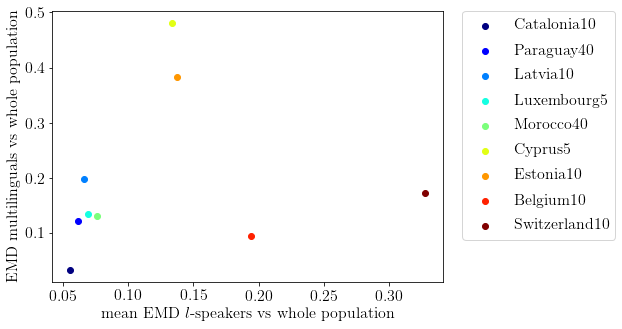

In [241]:
with open(save_path) as f:
    plot_countries_dict = json.load(f)

# cases_to_include = ['Balearic islands5', 'Balearic islands10', 'Galicia5', 
#                     'Galicia10', 'Valencian Community5', 'Valencian Community10',
#                     'Basque country5', 'Basque country10']
cases_to_include = [
    'Galicia10', 'Basque country5',
    'Switzerland10', 'Belgium10', 'Catalonia10',
    'Malaysia20', 'Indonesia40', 'Quebec20',
    'Latvia10', 'Estonia10', 'Cyprus5', 'Morocco40', 'Luxembourg5', 'Paraguay40']
# cases_to_include = ['Switzerland10', 'Switzerland15', 'Belgium5', 'Belgium10', 'Belgium15', 'Catalonia10']
# cases_to_include = ['Texas20', 'Louisiana20', 'New Mexico20', 'California20', 'Nevada20', 'Arizona20']
plot_countries_dict = {
    case_name: case_dict for case_name, case_dict in plot_countries_dict.items()
    if case_name in cases_to_include}
#     if case_name not in cases_to_exclude}
langs_metric = 'EMD_langs'
# langs_metric_label = 'EMD lang vs lang'
langs_metric_label = r'mean EMD $l$-speakers vs whole population'
# langs_metric_label = r'$\hat{H}^p$ mono/multi-lingual groups'
# langs_metric_label = r'$H_c$ $l$-speakers'
multiling_metric = 'EMD_multi'
multiling_metric_label = 'EMD multilinguals vs whole population'
# multiling_metric_label = r'KS multilinguals vs whole population'
# multiling_metric_label = r'$H_c$ mono/multi-lingual groups'
region_to_del = []
for region, region_dict in plot_countries_dict.items():
    if (region_dict[langs_metric] is None) or (region_dict[multiling_metric] is None):
        region_to_del.append(region)
for region in region_to_del:
    del plot_countries_dict[region]
        
countries = [case_dict['name'] for case_dict in plot_countries_dict.values()]
lang_metrics = [case_dict[langs_metric] for case_dict in plot_countries_dict.values()]
multi_metrics = [case_dict[multiling_metric] 
                 for case_dict in plot_countries_dict.values()]
sorted_lists = sorted(zip(lang_metrics, multi_metrics, countries), 
                      key=lambda t: t[0])
lang_metrics, multi_metrics, countries = zip(*sorted_lists)
# Get a 2D array, each row containing the 4 RGBA values
colors = plt.cm.get_cmap('jet', len(countries))
fig, ax = plt.subplots(1, figsize=(7, 5))
for i, cc in enumerate(countries):
    # The color must be a matrix, so we reshape to make the RGBA vector a single 
    # line matrix
    plt.scatter(lang_metrics[i], multi_metrics[i], label=cc, c=(colors(i),))
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.xlabel(langs_metric_label)
plt.ylabel(multiling_metric_label)
file_path = os.path.join(fig_dir, 'all', 
                         f'phase_space_{langs_metric}_vs_{multiling_metric}_others.pdf')
plt.savefig(file_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

then recalculate EMD and Hp after n iterations to see how the point moves around

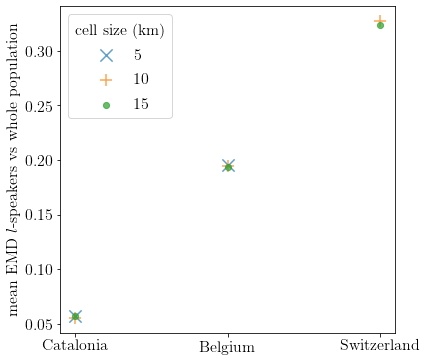

In [311]:
with open(save_path) as f:
    plot_countries_dict = json.load(f)

fig, ax = plt.subplots(1, figsize=(6, 6))
xticks = np.array([1, 2, 3])
p1 = ax.scatter(
    xticks[:-1], 
    [plot_countries_dict['Catalonia5']['EMD_langs'],
     plot_countries_dict['Belgium5']['EMD_langs']],
    alpha=0.7,
    label='5',
    marker='x', s=150)
p2 = ax.scatter(
    xticks,
    [plot_countries_dict['Catalonia10']['EMD_langs'],
     plot_countries_dict['Belgium10']['EMD_langs'],
     plot_countries_dict['Switzerland10']['EMD_langs']],
    alpha=0.7,
    label='10',
    marker='+', s=150)
    
p3 = ax.scatter(
    xticks,
    [plot_countries_dict['Catalonia15']['EMD_langs'],
     plot_countries_dict['Belgium15']['EMD_langs'],
     plot_countries_dict['Switzerland15']['EMD_langs']],
    alpha=0.7,
    label='15',
    marker='.', s=150)#, facecolors='none', edgecolors='g')
ax.set_xticks(xticks)
ax.set_xticklabels(('Catalonia', 'Belgium', 'Switzerland'))
ax.set_ylabel(r'mean EMD $l$-speakers vs whole population')
ax.legend(title='cell size (km)')
plt.savefig(os.path.join(fig_dir, 'all', 'EMD_cell_size_invariance.pdf'),
            bbox_inches='tight')
plt.show()